#<고군산군도 카페 리뷰 감성분석>
고군산군도에 위치한 카페들의 리뷰를 구글, 네이버에서 크롤링 해온 뒤 소비자들이 어떤 부분에 대해 긍정.부정 감정을 느끼고 있는지 감성분석을 진행하고 해당 결과를 워드클라우드로 시각화해 보았습니다.

In [1]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

c:\Users\Laptop\Documents\GitHub\BigContest\카페검색량&리뷰\Mecab-ko-for-Google-Colab


Cloning into 'Mecab-ko-for-Google-Colab'...


In [2]:
!apt -qq -y install fonts-nanum > /dev/null
 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font = fm.FontProperties(fname=fontpath, size=10)
fm._rebuild()
 
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'
 
# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

������ ��θ� ã�� �� �����ϴ�.
Matplotlib is building the font cache; this may take a moment.


In [6]:
!pip install tensorflow


ERROR: Could not install packages due to an EnvironmentError: [Errno 28] No space left on device



In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

ModuleNotFoundError: No module named 'tensorflow'

# 학습 데이터 전처리

네이버 쇼핑 리뷰 데이터 불러오기

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7f2b1326dc90>)

In [ ]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


별점으로 긍정 부정 Labelling진행
(긍정 :1, 부정 :0)

In [ ]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [ ]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [ ]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 199908


In [ ]:
print(total_data.isnull().values.any())

False


In [ ]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


불용어 제거

In [ ]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

ratings    0
reviews    0
label      0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49977


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

형태소 분석 & 불용어 제거

In [ ]:
mecab = Mecab()

stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [ ]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 31799), ('는데', 20295), ('안', 19718), ('어요', 14849), ('있', 13200), ('너무', 13058), ('했', 11783), ('좋', 9812), ('배송', 9677), ('같', 8997), ('구매', 8876), ('어', 8869), ('거', 8854), ('없', 8670), ('아요', 8642), ('습니다', 8436), ('그냥', 8355), ('되', 8345), ('잘', 8029), ('않', 7984)]


In [ ]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 39488), ('아요', 21184), ('네요', 19895), ('어요', 18686), ('잘', 18602), ('구매', 16171), ('습니다', 13320), ('있', 12391), ('배송', 12275), ('는데', 11670), ('했', 9818), ('합니다', 9801), ('먹', 9635), ('재', 9273), ('너무', 8397), ('같', 7868), ('만족', 7261), ('거', 6482), ('어', 6294), ('쓰', 6292)]


긍정 리뷰의 평균 길이 : 13.587751456414221
부정 리뷰의 평균 길이 : 17.02953896259911


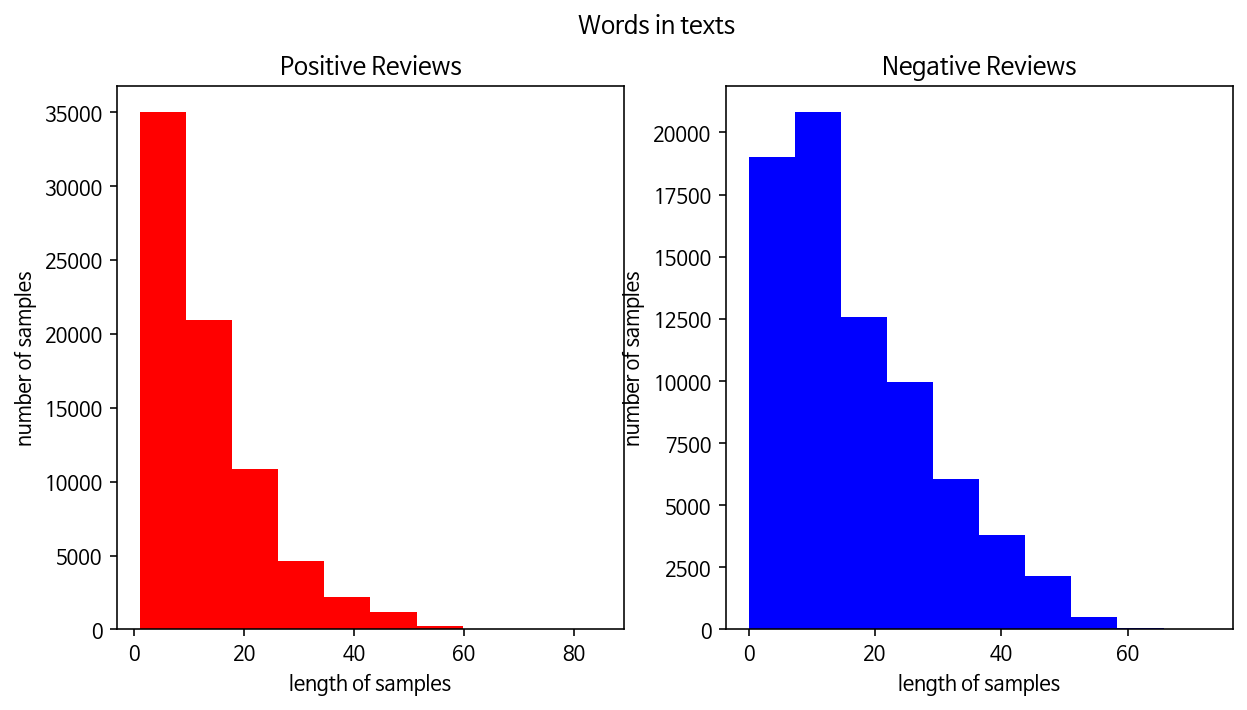

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [ ]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

Vectorization

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 39997
등장 빈도가 1번 이하인 희귀 단어의 수: 18212
단어 집합에서 희귀 단어의 비율: 45.53341500612546
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7935245745567578


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 21787


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.307554808545264


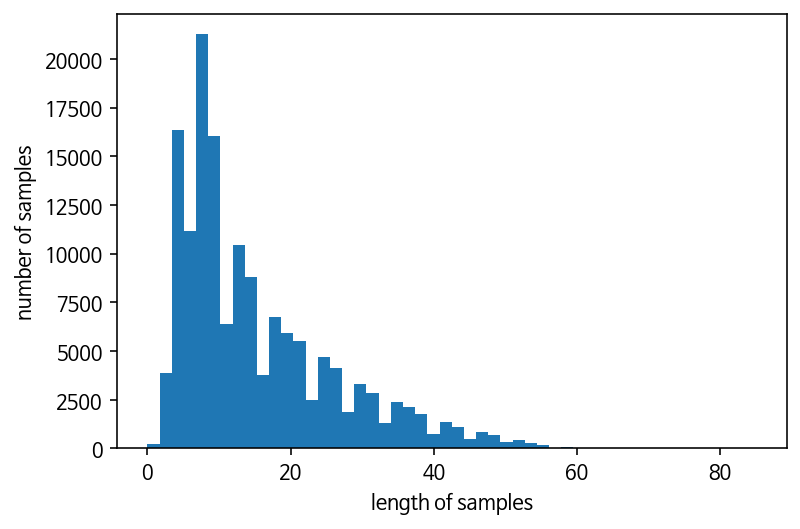

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


Padding

In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# GRU 모델 이용해서 학습시키기

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
2000/2000 [==============================] - 271s 134ms/step - loss: 0.2729 - acc: 0.8970 - val_loss: 0.2264 - val_acc: 0.9183

Epoch 00001: val_acc improved from -inf to 0.91826, saving model to best_model.h5
Epoch 2/15
2000/2000 [==============================] - 269s 135ms/step - loss: 0.2155 - acc: 0.9222 - val_loss: 0.2103 - val_acc: 0.9239

Epoch 00002: val_acc improved from 0.91826 to 0.92393, saving model to best_model.h5
Epoch 3/15
2000/2000 [==============================] - 266s 133ms/step - loss: 0.1987 - acc: 0.9285 - val_loss: 0.2031 - val_acc: 0.9278

Epoch 00003: val_acc improved from 0.92393 to 0.92777, saving model to best_model.h5
Epoch 4/15
2000/2000 [==============================] - 268s 134ms/step - loss: 0.1875 - acc: 0.9334 - val_loss: 0.2108 - val_acc: 0.9231

Epoch 00004: val_acc did not improve from 0.92777
Epoch 5/15
2000/2000 [==============================] - 267s 134ms/step - loss: 0.1780 - acc: 0.9373 - val_loss: 0.2172 - val_acc: 0.9225

Epo

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 32s 20ms/step - loss: 0.2100 - acc: 0.9249

 테스트 정확도: 0.9249


# LSTM을 이용해서 학습

In [ ]:
from tensorflow.keras.layers import LSTM

model2 = Sequential()
model2.add(Embedding(vocab_size, 100))
model2.add(LSTM(128))
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model_2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model2.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
2000/2000 [==============================] - 374s 186ms/step - loss: 0.2784 - acc: 0.8950 - val_loss: 0.2270 - val_acc: 0.9171

Epoch 00001: val_acc improved from -inf to 0.91710, saving model to best_model_2.h5
Epoch 2/15
2000/2000 [==============================] - 378s 189ms/step - loss: 0.2171 - acc: 0.9216 - val_loss: 0.2102 - val_acc: 0.9255

Epoch 00002: val_acc improved from 0.91710 to 0.92547, saving model to best_model_2.h5
Epoch 3/15
2000/2000 [==============================] - 374s 187ms/step - loss: 0.2006 - acc: 0.9282 - val_loss: 0.2104 - val_acc: 0.9250

Epoch 00003: val_acc did not improve from 0.92547
Epoch 4/15
2000/2000 [==============================] - 373s 187ms/step - loss: 0.1911 - acc: 0.9318 - val_loss: 0.2039 - val_acc: 0.9264

Epoch 00004: val_acc improved from 0.92547 to 0.92640, saving model to best_model_2.h5
Epoch 5/15
2000/2000 [==============================] - 404s 202ms/step - loss: 0.1831 - acc: 0.9356 - val_loss: 0.2047 - val_acc: 0.926

In [ ]:
loaded_model = load_model('best_model_2.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 43s 27ms/step - loss: 0.2113 - acc: 0.9242

 테스트 정확도: 0.9242


따라서 더 성능이 좋은 GRU를 이용하기로 함

#워드 클라우드 생성

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측

  return score

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/My Drive/chung_proj/최종/감정분석

/content/gdrive/My Drive/chung_proj/최종/감정분석


In [ ]:
train = pd.read_excel("선유도크롤링.xlsx")

In [ ]:
import re
train['review']=train['review'].map(lambda x: re.sub('[-,=.#/?:$}]','', x))
train['review'] = train['review'].map(lambda x: re.sub(r'\d+', '', x))

In [ ]:
train = train.reindex(columns = train.columns.tolist() + ["score_new"])

In [ ]:
for i in range(len(train)):
  train['score_new'][i] = sentiment_predict(train['review'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
train

,LABEL-1,LABEL-3,LABEL-4,LABEL-5,LABEL-12,review,store,score_new
0,https://lh3.googleusercontent.com/a-/AOh14Gjm9...,이훈주,지역 가이드,・리뷰 232개,2년 전,카페드선유는 선유도에 있는 카페인데\n리뷰 사진들이 왜 다 이상한게 있는지 모르겠다...,카페드선유,0.985885
1,https://lh3.googleusercontent.com/a-/AOh14Gj5K...,J-do SONG,지역 가이드,・리뷰 424개,1년 전,동네 유일의 커피숍인가요 몇개 있을법한데 한참 찾아 헤매여봐도 안보이더군요 양으로...,카페드선유,0.415589
2,https://lh3.googleusercontent.com/a-/AOh14Gi2L...,어르신을부탁해 재가복지센터,지역 가이드,・리뷰 209개,2년 전,선유도 스카이라인근처 카페로 커피맛도좋고 뷰도좋아요,카페드선유,0.969273
3,https://lh3.googleusercontent.com/a/AATXAJzwA8...,Seung Hun Lee,지역 가이드,・리뷰 25개,3달 전,커피맛이 % 부족합니다,카페드선유,0.045774
4,https://lh3.googleusercontent.com/a-/AOh14GhKs...,DJ구댕,지역 가이드,・리뷰 64개,1년 전,(토) 가족여행\n) 선유도간거임\n) 카페갔는데 사람이도없었음 왜없지\n) 사실옆...,카페드선유,0.794820
...,...,...,...,...,...,...,...,...
1586,NaN,NaN,지역 가이드,NaN,NaN,깔끔한 매장과 친절한 종업원들이 맞아주네요,NaN,0.980612
1587,NaN,NaN,지역 가이드,NaN,NaN,굿,NaN,0.873156
1588,NaN,NaN,지역 가이드,NaN,NaN,굿,NaN,0.873156
1589,NaN,NaN,지역 가이드,NaN,NaN,좋아요,NaN,0.823858


- 긍부정 문장들 나누기

In [ ]:
train = train.reindex(columns = train.columns.tolist() + ["pos_neg"])

In [ ]:
train

,LABEL-3,LABEL-4,LABEL-5,LABEL-12,review,store,score_new,pos_neg
0,이훈주,지역 가이드,・리뷰 232개,2년 전,카페드선유는 선유도에 있는 카페인데\n리뷰 사진들이 왜 다 이상한게 있는지 모르겠다...,카페드선유,0.985885,NaN
1,J-do SONG,지역 가이드,・리뷰 424개,1년 전,동네 유일의 커피숍인가요 몇개 있을법한데 한참 찾아 헤매여봐도 안보이더군요 양으로...,카페드선유,0.415589,NaN
2,어르신을부탁해 재가복지센터,지역 가이드,・리뷰 209개,2년 전,선유도 스카이라인근처 카페로 커피맛도좋고 뷰도좋아요,카페드선유,0.969273,NaN
3,Seung Hun Lee,지역 가이드,・리뷰 25개,3달 전,커피맛이 % 부족합니다,카페드선유,0.045774,NaN
4,DJ구댕,지역 가이드,・리뷰 64개,1년 전,(토) 가족여행\n) 선유도간거임\n) 카페갔는데 사람이도없었음 왜없지\n) 사실옆...,카페드선유,0.794820,NaN
...,...,...,...,...,...,...,...,...
1586,NaN,지역 가이드,NaN,NaN,깔끔한 매장과 친절한 종업원들이 맞아주네요,NaN,0.980612,NaN
1587,NaN,지역 가이드,NaN,NaN,굿,NaN,0.873156,NaN
1588,NaN,지역 가이드,NaN,NaN,굿,NaN,0.873156,NaN
1589,NaN,지역 가이드,NaN,NaN,좋아요,NaN,0.823858,NaN


In [ ]:
for i in range(len(train)):
  if train['score_new'][i] > 0.5:
    train['pos_neg'][i]= "긍정"
  else:
    train['pos_neg'][i]= "부정"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

In [ ]:
neg =train[train['pos_neg'] == '부정']
neg

,LABEL-3,LABEL-4,LABEL-5,LABEL-12,review,store,score_new,pos_neg
1,J-do SONG,지역 가이드,・리뷰 424개,1년 전,동네 유일의 커피숍인가요 몇개 있을법한데 한참 찾아 헤매여봐도 안보이더군요 양으로...,카페드선유,0.415589,부정
3,Seung Hun Lee,지역 가이드,・리뷰 25개,3달 전,커피맛이 % 부족합니다,카페드선유,0.045774,부정
6,백진영,지역 가이드,・리뷰 502개,1달 전,커피맛도 ㅠ\n서비스도 ㅠ,카페드선유,0.017363,부정
15,bs park,지역 가이드,・리뷰 191개,11달 전,그 카페근처에 짬뽕집 정말 정말 맛없음 서비스 개떡 그 동네도 두번다시 가기 싫어졌음,카페드선유,0.000897,부정
18,최현주,지역 가이드,・리뷰 92개,3년 전,바다 보이는 커피숍 입니다\n부부간에 운영하시는듯 사람이 만을땐\n조금 늦게 나...,카페드선유,0.046367,부정
...,...,...,...,...,...,...,...,...
1550,NaN,지역 가이드,NaN,NaN,복돼지 빵이 방금했다고 했는데ㅜㅜ다 식고 빵도 너무 두껍고ㅜㅜ먹다 말았어요ㅠ장자도에...,NaN,0.046032,부정
1557,NaN,지역 가이드,NaN,NaN,마시쯤,NaN,0.472903,부정
1564,NaN,지역 가이드,NaN,NaN,호떡당과 같은 집 입니다,NaN,0.487967,부정
1573,NaN,지역 가이드,NaN,NaN,바로구워주지않아서 별루요\n식은호떡 데워주는 기분이요\n이른시간도 아닌데 청소도 덜...,NaN,0.000688,부정


In [ ]:
#불용어 제거, token화 시키기
def text_preprocessing(text_list):
    
    stopwords = ['을', '를', '가','도','이','또는','및','의','은', '는','로','과','null'] #불용어 설정
    tokenizer = Mecab() #형태소 분석기 
    token_list = []
    
    for content in text_list:
        txt = re.sub('[^가-힣a-z]', ' ', str(content)) #한글이랑 영어 소문자만 남기고 다른 글자 모두 제거
        token = tokenizer.morphs(txt) #형태소 분석
        token = [t for t in token if t not in stopwords and type(t) != float] #형태소 분석 결과 중 stopwords에 해당하지 않는 것만 추출
        token_list.append(token)     
    
    return token_list, tokenizer
#token_list에는 쪼개진 단어(token)들이 들어있음

In [ ]:
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
import konlpy
from konlpy.tag import Mecab
import re

In [ ]:
neg =neg['review']

In [ ]:
review_neg, mecab = text_preprocessing(neg)

In [ ]:
#token들을 하나의 list로 합쳐주기!
result = []
for i in range(len(review_neg)):
  result.extend(review_neg[i])

In [ ]:
import nltk
from nltk import collocations

from konlpy.tag import Okt, Kkma
from konlpy.utils import pprint

from wordcloud import WordCloud, STOPWORDS
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
ko = nltk.Text(result)

In [ ]:
def wc(ko,num_words_):
    print( '단어수:',len(ko.tokens) , '안겹치는단어수:', len(set(ko.tokens)) )
    plt.figure(figsize=(12,5))
    ko.plot(50)
    plt.show()
    
    num_words = num_words_
    data = ko.vocab().most_common(num_words)
    wordcloud = WordCloud( background_color='white', font_path='/content/gdrive/MyDrive/chung_proj/BMDOHYEON_ttf.ttf').generate_from_frequencies(dict(data))
    plt.figure(figsize=(12,8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [ ]:
#추가불용어정의
불용어 = []
def add_stopwords(x):
    불용어.append(x)

In [ ]:
add_stopwords('너무')
add_stopwords('정말')
add_stopwords('가') 
add_stopwords('도')
add_stopwords('진짜') 
add_stopwords('네요') 
add_stopwords('어요') 
add_stopwords('요')
add_stopwords('진짜') 
add_stopwords('카페') 
add_stopwords('커피') 
add_stopwords('아요') 
add_stopwords('는데')
add_stopwords('아요') 
add_stopwords('습니다')
add_stopwords('에서')  
add_stopwords('해요') 
add_stopwords('지만') 
add_stopwords('합니다') 
add_stopwords('인데')
add_stopwords('으로') 
add_stopwords('세요')
add_stopwords('입니다') 
add_stopwords('그리고')
add_stopwords('어서') 
add_stopwords('에요') 
add_stopwords('면서') 
add_stopwords('해서') 
add_stopwords('라고') 
add_stopwords('아서') 
add_stopwords('으면') 
add_stopwords('은데') 
add_stopwords('까지') 
add_stopwords('인지') 
add_stopwords('으나') 
add_stopwords('이나') 
add_stopwords('구요') 

In [ ]:
ko_elim = [ x for x in ko if (x not in 불용어) & (len(x)>1) ]
print( len(ko), len(ko_elim) )
ko_elim = nltk.Text(ko_elim)

4627 1928


단어수: 1928 안겹치는단어수: 928


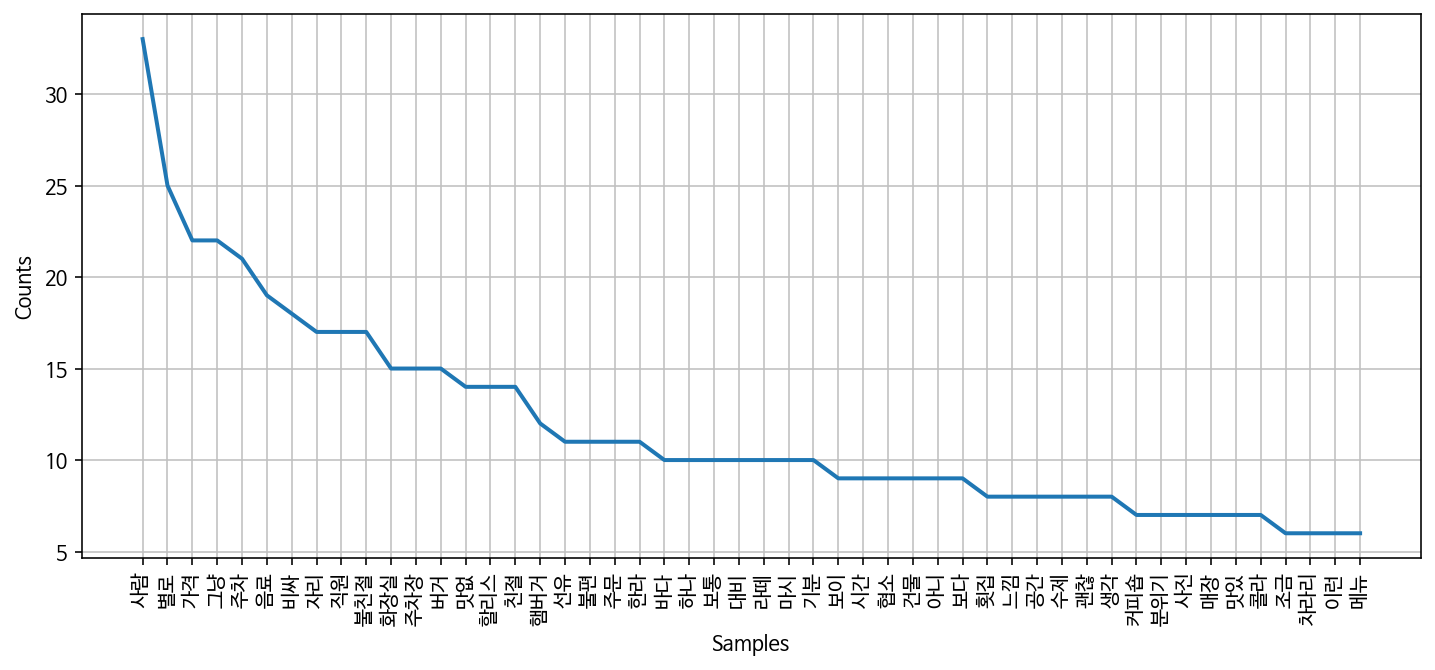

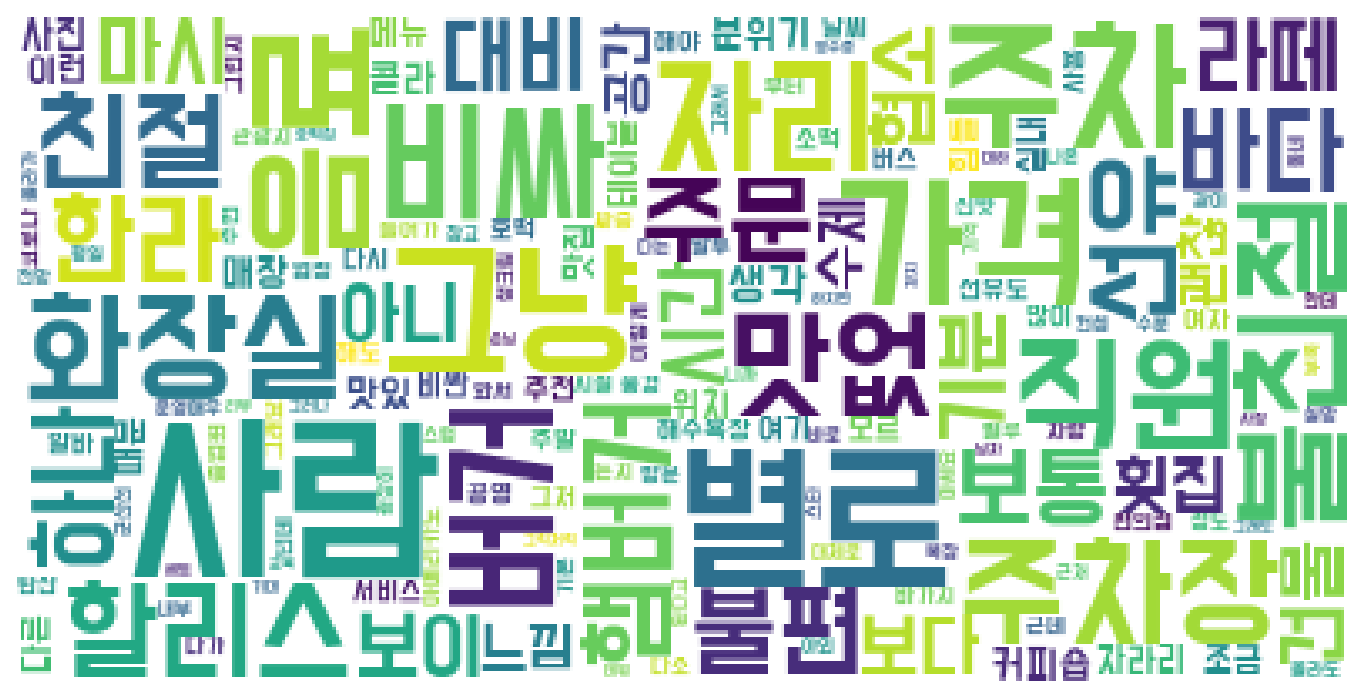

In [ ]:
wc(ko_elim,500)

#긍정

In [ ]:
pos =train[train['pos_neg'] == '긍정']
pos

,LABEL-3,LABEL-4,LABEL-5,LABEL-12,review,store,score_new,pos_neg
0,이훈주,지역 가이드,・리뷰 232개,2년 전,카페드선유는 선유도에 있는 카페인데\n리뷰 사진들이 왜 다 이상한게 있는지 모르겠다...,카페드선유,0.985885,긍정
2,어르신을부탁해 재가복지센터,지역 가이드,・리뷰 209개,2년 전,선유도 스카이라인근처 카페로 커피맛도좋고 뷰도좋아요,카페드선유,0.969273,긍정
4,DJ구댕,지역 가이드,・리뷰 64개,1년 전,(토) 가족여행\n) 선유도간거임\n) 카페갔는데 사람이도없었음 왜없지\n) 사실옆...,카페드선유,0.794820,긍정
5,커핀보이,지역 가이드,・리뷰 153개,1년 전,깨끗하고 바닷가상점 비해서 정감있고 뷰도 좋아요\n그에비해 가격은 착한편,카페드선유,0.925883,긍정
7,이건희,지역 가이드,・리뷰 233개,2년 전,선유도에서 깔끔하고 멋있는 카페는 여기뿐입니다,카페드선유,0.972918,긍정
...,...,...,...,...,...,...,...,...
1586,NaN,지역 가이드,NaN,NaN,깔끔한 매장과 친절한 종업원들이 맞아주네요,NaN,0.980612,긍정
1587,NaN,지역 가이드,NaN,NaN,굿,NaN,0.873156,긍정
1588,NaN,지역 가이드,NaN,NaN,굿,NaN,0.873156,긍정
1589,NaN,지역 가이드,NaN,NaN,좋아요,NaN,0.823858,긍정


In [ ]:
pos =pos['review']

In [ ]:
review_pos, mecab = text_preprocessing(pos)

In [ ]:
#token들을 하나의 list로 합쳐주기!
result2 = []
for i in range(len(review_pos)):
  result2.extend(review_pos[i])

In [ ]:
ko2 = nltk.Text(result2)

In [ ]:
ko_elim2 = [ x for x in ko2 if (x not in 불용어) & (len(x)>1) ]
print( len(ko2), len(ko_elim2) )
ko_elim2 = nltk.Text(ko_elim2)

11355 4455


단어수: 4455 안겹치는단어수: 1320


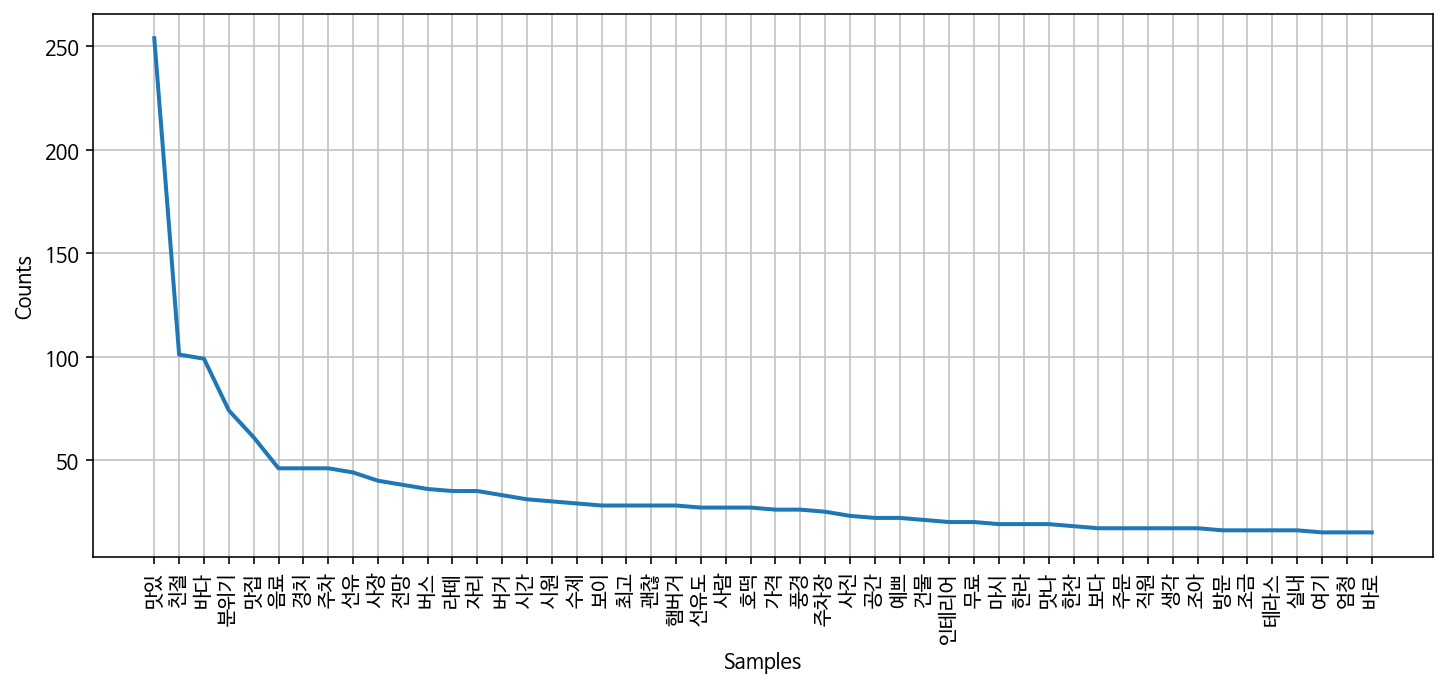

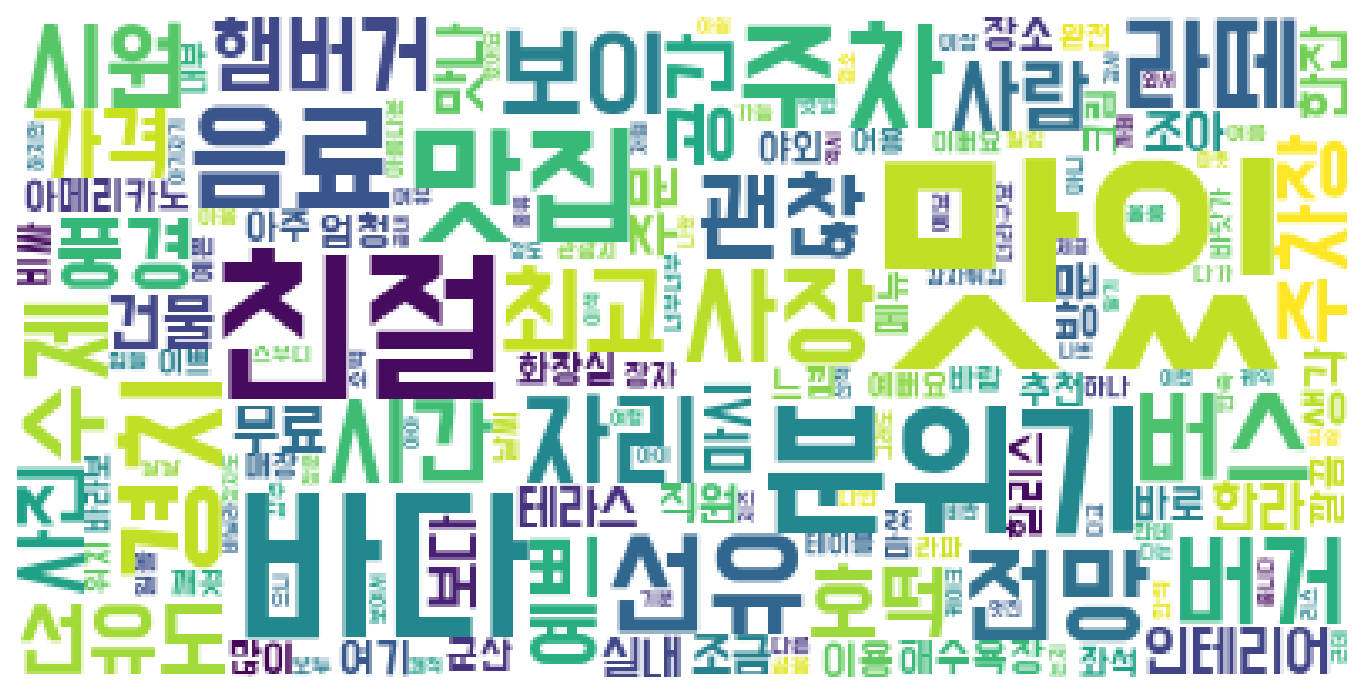

In [ ]:
wc(ko_elim2,500)